# Manipulating markets in ecoinvent 3
### By James Joyce

### Part of the 'future ecoinvent' group project

## The challenge

LCA can be a powerful tool for demonstrating the environmental credentials of products and technologies that are in development. When future products or technologies are assessed using LCA, while the foreground system can be manipulated to reflect the world they are likely to be released into, the background system is static, reflecting current technology mixes. This might lead to inconsistencies when assessing future scenarios using LCA.

For example, decarbonisation of the electricity grid is likely to improve the global warming impact associated with the life cycle of electric vehicles. In a standard LCA, the foreground system can be altered to utilise lower carbon electricity sources in the use phase. It may also be possible to alter the electricity mix used by the assembly process and the production of key components. However, as the supply chain gets more and complex and intertwined, manual edits to the electricity mix used become burdensome.

Similarly, aluminium is replacing steel in a number of new products with it's lightweight properties billed as reducing environmental impact (e.g. car engine blocks ([Bonollo et al. 2006](http://www.gruppofrattura.it/ors/index.php/MST/article/viewFile/1119/1071))). However, concurrently the production of aluminium is shifting towards China. From almost a standing start in the late 90's, China accounted for over half of primary aluminium production in 2015.

![Proportion of primary aluminium production](https://i.imgsafe.org/3d7bb5354c.png)

Aluminium smelting requires a large amount of electricity (around 14 kWh/kg), which in China is mainly produced at coal fired power stations. As a result, the net benefits from lightweighting may diminish as the impact of aluminium production with coal power increases.

By making targeted alterations to the system model that builds the background database, markets for exchanges such as electricity, aluminium, or any other exchange, can be updated database-wide to reflect the future scenario we are seeking to assess with our LCA. If the process is simple enough, powerful sensitivity analyses may be possible where products or technologies can be tested out according to a variety of possible future scenarios.

## The idea

The aim of this element of the project was to create a simple way to use external data (in the form of a machine readable .csv file) to manipulate the composition of markets within the ecoinvent database.
In order to create markets, the Ocelot linking algorithm uses the relative share of production volumes in the regions contained within that market to allocate and despatch the demand. By editing the production volumes of targeted transformation processes during the construction of the system model, the resulting markets can be manipulated to represent any mix desired by the user

## Visual representation

![Market manipulation diagram](https://i.imgsafe.org/10f3528188.png)

*For a given number of transforming activites within a region, the production volume of the reference product is changed using external data, and these altered production volumes (PV') are used to direct the linking for the appropriate regional market*

## Preparing the external data

Each transforming process in the ecoinvent database is identified by a universally unique identifier.
These can be found in the [activity overview](http://www.ecoinvent.org/support/documents-and-files/information-on-ecoinvent-3/information-on-ecoinvent-3.html) spreadsheet available from the econinvent website.

The file used to manipulate the markets consists of two columns, one for uuid, and one for the new production volume.

For example:

|                uuid                |production volume|
|:----------------------------------:|----------------:|
|7f093291-b86f-40c8-933e-90b18711a515|123456           |
|be256386-9de6-43c3-8b1f-0dacdce19312|756543           |
|...                                 |...              |

The default setting for reading the file is separated by commas, with a header row, i.e.:

```
uuid,"production volume"
7f093291-b86f-40c8-933e-90b18711a515,123456
be256386-9de6-43c3-8b1f-0dacdce19312,756543
```
however, this can be altered by changing the ```sep``` and ```header``` keyword arguments in `read_edit_csv`

## The code

The code is stored as a module called `market_manipulator`

This includes some utility functions (`get_dataset_by_id` and `get_dataset_by_code`) used within the new transformation function, and also some output functions (`list_techno_inputs`) to see the effects of our changes.

The main module includes a function to read the .csv file into the format required by the new transformation function
(a dictionary with the id of the transformation process as the key and the new production volume as the value)

```python

def read_edit_csv(filename, sep = ",", header=True):
    """read a csv file (column 0 = ids, column 1 = new production volumes) into the format required by edit_pv_of_reference_products"""
    with open(filename) as csvfile:

        my_edits = {}

        for i, line in enumerate(csvfile):
            if header == False or i>0:
                ls = line.strip().split(sep)
                my_edits[ls[0]]=ls[1]

        return my_edits
        
```

Below is the full version of the new transformation function to be used in the compilation of the system model

It takes two positional arguments, the first is the dataset being transformed, the second is the dictionary of edits to make, in the format output by `read_edit_csv`

This function changes the production volumes of the reference product of the specified transforming activities and logs the changes made

```python
import logging

def edit_pv_of_reference_products(data, edits_to_make):
    """edit the production volumes of a set of activities
        this is specified in a dictionary with the keys as the ids and the values as the new production volume
        Note - this function is 'curried' with its dictionary to become edit_specified_pvs(data)"""
   
    for edit in edits_to_make:
        dataset = get_dataset_by_id(edit, data)
        ref_product = get_single_reference_product(dataset)
        original_pv = ref_product['production volume']['amount']
        new_pv = edits_to_make[edit]
        ref_product['production volume']['amount'] = float(new_pv)
        print ('Production volume for {} {} changed from {} to {}'.format(dataset['name'], dataset['location'],original_pv, new_pv))
        logging.info({
                'type': 'table element',
                'data': (dataset['name'], dataset['location'],original_pv, new_pv)
            })
    return data

edit_pv_of_reference_products.__table__ = {
    'title': 'Alter the production volume of specified transforming activities',
    'columns': ["Activity", "Location", "Original", "New"]
}
```

`read_edit_csv` and `edit_pv_of_reference_products` can be imported and utilised in the generation of alternative system models.

To make life slightly easier however, we can write an alternative version of Ocelot's built in `system_model` function to apply the edits in our csv file to the default Ocelot configuration.

This function takes two arguments, the path to the ecospold files and the path to the .csv file

It returns the results of `system_model` using the new configuration which it sets up.

First it imports the elements of Ocelot it requires (`system_model`, `default_configuration` and `link_markets`), and `partial` from `functools`.

Then it uses `read_edit_csv` to read in the specified file of edits.

In order for the transformation function to be applied by the Ocelot `system_model` function, the external data needs to be 'curried' into a function that takes the dataset as a single positional argument. This function is called `edit_specified_pvs`

Next, we need to create a new, custom configuration. We do this by finding the `link_markets` collection in the `default_configuration` and inserting our new `edit_specified_pvs` function beforehand.

Finally we run `system_model` on our data files using our new configuration and return the filepath and the data.

```python
def system_model_with_pv_edits (data_path, edit_csv_file):
    from ocelot import system_model, default_configuration
    from ocelot.transformations.locations import link_markets    
    from functools import partial
    
    my_edits = read_edit_csv(edit_csv_file)

    edit_specified_pvs = partial(edit_pv_of_reference_products, edits_to_make=my_edits)

    linking_function_index = default_configuration.index(link_markets)

    custom_configuration = list(default_configuration)
    custom_configuration.insert(linking_function_index, edit_specified_pvs)

    # run the system model
    fp, data = system_model(data_path, custom_configuration)
    
    return fp, data
```

## Case study - Aluminium production moving to China

Below is an example, in which we change the market for aluminium such that 80% of primary ingot is produced in China. Given the current rate of growth of China's market share, this may become a reality in the next decade.

In [1]:
from market_manipulator import system_model_with_pv_edits

#new_pv_file = "path/to/edits.csv"
new_pv_file = "AluminiumIngot80%CN.csv"

# data_path = "path/to/unlinked/ecospold/files"  <- To run interactively, change this to point to a local version
data_path = r"C:\Users\pjjoyce\Documents\01_OcelotLargeFiles\ecoinvent32"

fp, data = system_model_with_pv_edits(data_path, new_pv_file)

Starting Ocelot model run
Using cached ecospold2 data
Opening log file at: C:\Users\pjjoyce\AppData\Local\ocelot_project\Ocelot\model-runs\9f9d311f7b2948eaae41a2c5253c6856\report.log.json
Applying transformation variable_names_are_unique
Applying transformation ensure_markets_only_have_one_reference_product
Applying transformation ensure_markets_dont_consume_their_ref_product
Applying transformation fix_specific_ecoinvent_issues
Applying transformation replace_implicit_references
Applying transformation repair_all_uncertainty_distributions
Applying transformation fix_known_bad_formula_strings
Applying transformation lowercase_all_parameters
Applying transformation fix_math_formulas
Applying transformation replace_reserved_words
Applying transformation delete_unparsable_formulas
Applying transformation ensure_production_exchanges_have_production_volume
Applying transformation add_pv_to_allocatable_byproducts
Applying transformation create_pv_parameters
Applying transformation remove_con

<string>:8: (WARNING/2) Block quote ends without a blank line; unexpected unindent.
<string>:8: (WARNING/2) Block quote ends without a blank line; unexpected unindent.


## So what have we done?

If we know the id of the market process we want to have altered, we can use the `list_techno_inputs` utility function from the `market_manipulator` module to check the inputs to the market. If the new system model has worked, 80% of the inputs of aluminium should be from China

In [2]:
from market_manipulator.outputs import list_techno_inputs

RoW_Al_market = "92bb65cf-89fa-45f1-9b40-38d762e16805"
list_techno_inputs(RoW_Al_market,data)

There are 9 inputs to the technosphere in market for aluminium, primary, ingot RoW


,name,location,amount,unit,percentage
6,"aluminium production, primary, ingot",CN,0.8000,kg,80.00%
2,"aluminium production, primary, ingot","IAI Area, Europe outside EU & EFTA",0.0391,kg,3.91%
4,"aluminium production, primary, ingot",IAI Area 8,0.0341,kg,3.41%
3,"aluminium production, primary, ingot",IAI Area 4&5 without China,0.0283,kg,2.83%
8,"aluminium production, primary, ingot",CA-QC,0.0227,kg,2.27%
0,"aluminium production, primary, ingot","IAI Area 2, without Quebec",0.0210,kg,2.10%
5,"aluminium production, primary, ingot",UN-OCEANIA,0.0204,kg,2.04%
1,"aluminium production, primary, ingot",IAI Area 3,0.0191,kg,1.91%
7,"aluminium production, primary, ingot",IAI Area 1,0.0153,kg,1.53%


Success! Next we can load this new database into brightway2 to see what effect this has had on the impact assessment results

## Comparing the new system model to the default in brightway2


#### << Warning! The next few cells contain the code required to create the results interactively >>
These can be skipped if you're not running the notebook interactively, the interesting parts follow


First we need to run the default configuration system model to compare to (We'll do this one silently to save space)

In [3]:
%%capture
from ocelot import system_model
def_fp, def_data = system_model(data_path);

Import brightway 2, and the Ocelot to brightway IO module

In [4]:
from brightway2 import *

Open or create and set up the SummerSchoolReport project

In [5]:
if "SummerSchoolReport" not in projects:
    print("Creating 'SummerSchoolReport' project")
    projects.set_current("SummerSchoolReport")
    bw2setup() # if its new, run `bw2setup()` to set up the biosphere flows and methods
else:
    print("Switching to 'SummerSchoolReport' project")
    projects.set_current("SummerSchoolReport")


Switching to 'SummerSchoolReport' project


In [6]:
from ocelot.io.brightway2 import import_into_brightway2

def try_database_import(data, name, overwrite=False):

    if name in databases:
        if overwrite:
            del databases[name]
            db = import_into_brightway2(data, name)
            print('{} overwritten'.format(name))
        else:
            db = Database(name)
            print("{} already exists so I've given you the current version.\nSet overwrite to True to overwrite the current version".format(name))
    else:
        db = import_into_brightway2(data, name)
        print('{} created'.format(name))
    return db

Import the two newly created databases into brightway2

In [7]:
new_database_name = "Ecoinvent32_cutoff_AlCN80"
new_db = try_database_import(data, new_database_name)

Ecoinvent32_cutoff_AlCN80 already exists so I've given you the current version.
Set overwrite to True to overwrite the current version


In [8]:
default_database_name = "Ecoinvent32_cutoff"
def_db = try_database_import(def_data, default_database_name)

Ecoinvent32_cutoff already exists so I've given you the current version.
Set overwrite to True to overwrite the current version


Next we can choose some methods to use in our assessment

In [9]:
my_methods = {
    'GWP' : [('IPCC 2013', 'GWP', '100 years'), 'Global warming potential (kg CO2-eq)'],
    'ECO' : [('ReCiPe Endpoint (E,A)', 'ecosystem quality', 'total'),'Ecosystem quality (ReCiPe points)'],
    'HUM' : [('ReCiPe Endpoint (E,A)', 'human health', 'total'),'Human health (ReCiPe points)'],
    'RES' : [('ReCiPe Endpoint (E,A)', 'resources', 'total'),'Resource depletion  (ReCiPe points)']
    }

Then create LCA objects for the default and newly customised database, compute the LCI, with factorisation, and then run the LCIA.

In [10]:
def switch_method(db, method):
    my_lca = LCA({db.random(): 1}, method=method)
    my_lca.lci(factorize=True)
    my_lca.lcia()
    
    return my_lca

In [11]:
def_lca = switch_method(def_db, my_methods['GWP'][0])

In [12]:
new_lca = switch_method(new_db, my_methods['GWP'][0])

These functions make it easier to assess and visualise our results

In [13]:
def check_method():
    m = def_lca.method
    for i in my_methods.keys():
        if m in my_methods[i]:
            r = my_methods[i][1]
            break
    return r

In [14]:
# Render our plots inline
%matplotlib inline

    
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)



def check_results(search_term):
    """Search for something in the databases and create a table and chart of LCIA results for each item you find"""
    pd.options.display.float_format = '{:.2f}'.format
    
    results = []
    max_results = 12
    too_many = False
    
    def_search = sorted(def_db.search(search_term))
    new_search = sorted(new_db.search(search_term))
    
    if len(def_search) + len(new_search) == 0:
        return 'Nothing found, sorry...'
    
    for i, item in enumerate(def_search):
        if i > max_results:
            too_many=True
            break
        def_lca.redo_lcia({item: 1})
        results.append({'item':"{} | {}".format(item['name'],item['location']), 'amount':'1 {}'.format(item['unit']), 'score':def_lca.score, 'database':def_db.name})
        
    for i, item in enumerate(new_search):
        if i > max_results:
            too_many=True
            break
        new_lca.redo_lcia({item: 1})
        results.append({'item':"{} | {}".format(item['name'],item['location']), 'amount':'1 {}'.format(item['unit']), 'score':new_lca.score, 'database':new_db.name})
        
    if too_many:
        print ('More than max number of items ({}) found, only first {} shown'.format(max_results, max_results))
    df = pd.DataFrame(results)[['item', 'database', 'amount','score']]
    
    p = df.groupby(['item', 'database']).agg(sum)
   
    p = p.unstack()
    p.columns = p.columns.droplevel()
    
    p['% difference']= ((p[new_db.name]-p[def_db.name])/p[def_db.name])*100
    
    p.sort_values('% difference', ascending=False, inplace =True)
    
    plotdata = p.drop('% difference',axis=1)
    
    l_names =p.index.tolist()
    
    from textwrap import fill
    wrapAt = int(120/len(l_names))
    labels = [ fill(l, wrapAt, break_long_words=False) for l in l_names]
    
    plot = plotdata.plot(kind='bar', rot=0)
    plot.set_xticklabels(labels)
    plot.legend(loc='upper right', bbox_to_anchor=(1, 1.2))
    t = check_method()
    plot.set_title(label=t)
    
    return plot, p    
    


## << Code block over, interesting bits start here >>

### Aluminium production

database,Ecoinvent32_cutoff,Ecoinvent32_cutoff_AlCN80,% difference
item,,,
"aluminium ingot, primary, to aluminium, cast alloy market | GLO",18.05,20.62,14.26
"aluminium ingot, primary, to aluminium, wrought alloy market | GLO",18.05,20.62,14.26
"market for aluminium, primary, ingot | RoW",18.05,20.62,14.26
"market for aluminium, primary, ingot | IAI Area, EU27 & EFTA",9.93,9.93,0.03


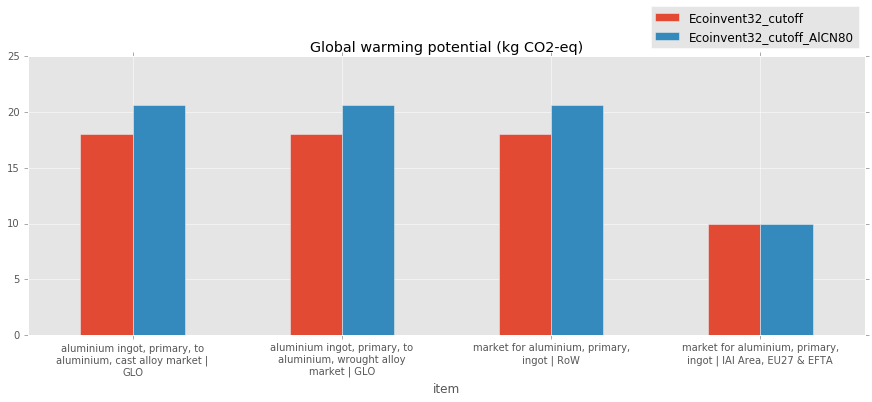

In [15]:
plot,table = check_results('market aluminium ingot')
table

The GWP impact of the RoW market for primary aluminium ingot and GLO markets for wrought and cast alloy (which take primary ingot as an input) have been affected by the changes to the system model. They have increased by around 14%. This is likely to be due to the predominant use of electricity from coal in the Hall-Héroult process.

It's interesting to note that the market for aluminium in the EU (where no aluminium is imported from China) is relatively unaffected, with only a 0.03% increase in impact. This means that we haven't directly affected this market, but the changes we've made to RoW aluminium seem to have propagated through the database and led to a slight increase as a result of distant inputs to the process. This is exactly what we wanted.

If we look at ecosystem effects we see a similar, if less pronounced, effect (increase of 3.58% for RoW and GLO markets, 0.01% for EU)

In [16]:
def_lca = switch_method(def_db, my_methods['ECO'][0])
new_lca = switch_method(new_db, my_methods['ECO'][0])

database,Ecoinvent32_cutoff,Ecoinvent32_cutoff_AlCN80,% difference
item,,,
"aluminium ingot, primary, to aluminium, cast alloy market | GLO",0.89,0.92,3.58
"aluminium ingot, primary, to aluminium, wrought alloy market | GLO",0.89,0.92,3.58
"market for aluminium, primary, ingot | RoW",0.89,0.92,3.58
"market for aluminium, primary, ingot | IAI Area, EU27 & EFTA",0.62,0.62,0.01


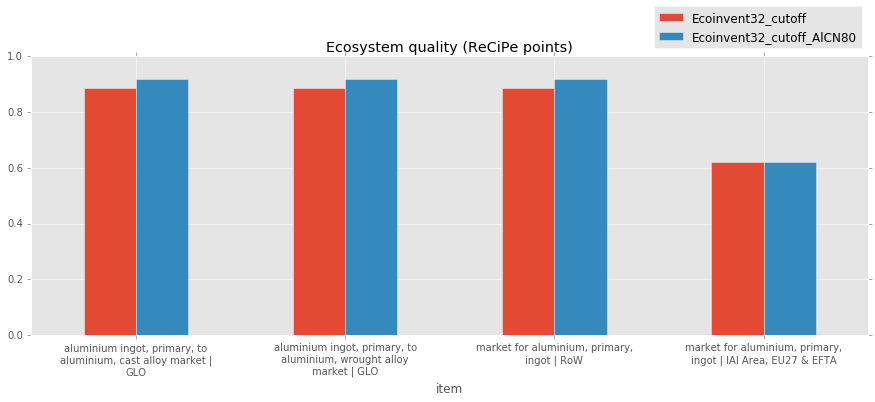

In [17]:
plot,table = check_results('market aluminium ingot')
table

### Products known to contain aluminium

We can extend our analysis explore the propagation of our changes through the background database.
Switching back to GWP impact, we can look at products which we know to contain aluminium, for example aluminium window frames.
Again we can see that we have brought about an increase, this time of (12.25%) as a result of increasing the impact of aluminium.

In [18]:
def_lca = switch_method(def_db, my_methods['GWP'][0])
new_lca = switch_method(new_db, my_methods['GWP'][0])

database,Ecoinvent32_cutoff,Ecoinvent32_cutoff_AlCN80,% difference
item,,,
"window frame production, aluminium, U=1.6 W/m2K | RoW",845.06,948.57,12.25


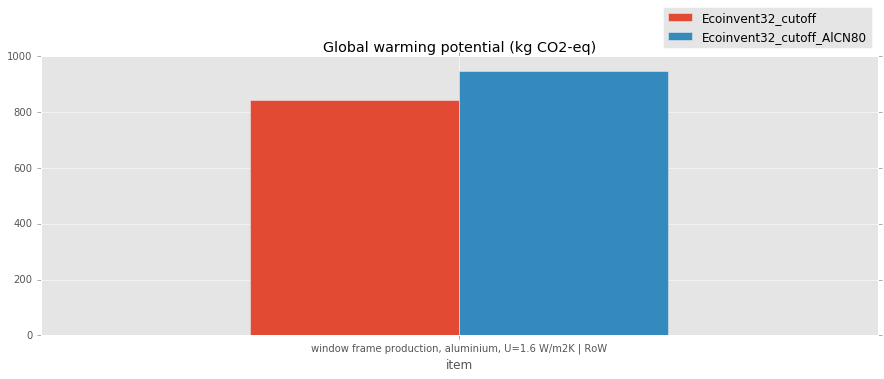

In [19]:
plot, table = check_results('window frame production aluminium RoW')
table

### Looking more broadly

Taking a broader approach, we can look at things that are likely to have aluminium in their supply chain as a component of a constituent part, for example passenger cars.
Here we can see that the percentage differences as a result of our changes vary between 0.25% and 6.41%, most likely related to the amount of aluminium in the various components.

database,Ecoinvent32_cutoff,Ecoinvent32_cutoff_AlCN80,% difference
item,,,
"charger production, for electric passenger car | GLO",25.58,27.22,6.41
"electric motor production, vehicle (electric powertrain) | GLO",10.88,11.52,5.91
"powertrain production, for electric passenger car | GLO",17.21,18.14,5.39
"internal combustion engine production, passenger car | GLO",6.05,6.38,5.31
"inverter production, for electric passenger car | GLO",35.87,37.66,4.98
"converter production, for electric passenger car | GLO",34.36,35.95,4.63
"power distribution unit production, for electric passenger car | GLO",35.32,36.87,4.40
"passenger car production, diesel | GLO",5.54,5.65,1.93
"passenger car production, petrol/natural gas | GLO",5.50,5.59,1.70


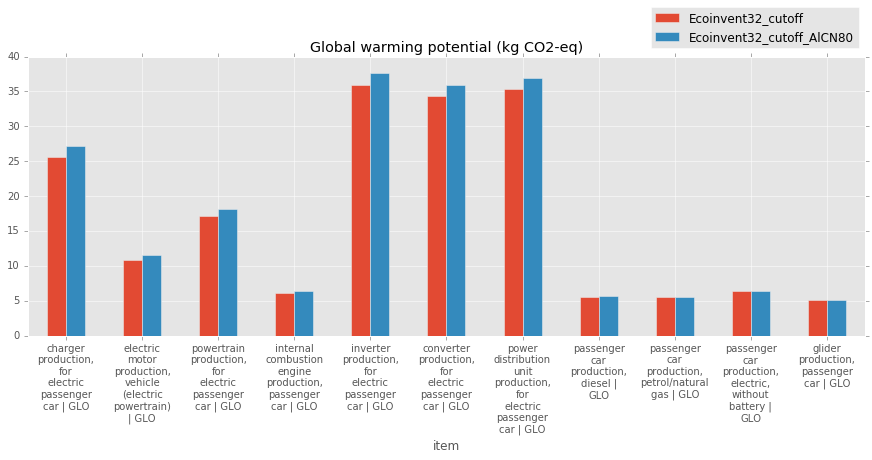

In [20]:
plot, table = check_results('passenger car production')
table

## Conclusions and next steps

We set out to create a simple way for LCA practitioners to manipulate the make up of markets within the ecoinvent database in such a way that these changes propagate through the database and influence the entire background system.
The newly created `market_manipulator` module does just this. 
With two commands...

```python
from market_manipulator import system_model_with_pv_edits

fp, data = system_model_with_pv_edits('path/to/unlinked/spold/files', 'path/to/csv/file')
```

...the production volumes, and hence the resulting market for a given exchange can be edited. The practitioners themselves just need to know how to create the csv and they can use it straight away without needing to know the detail behind it.

As the results show, throwing a stone of this kind into the ecoinvent 'pond' creates ripples throughout the database. Manipulating the market for aluminium for example, affects a wide number of processes to a greater or lesser extent.

Two lines of future development are immediately apparent. 

Firstly, for some markets the opportunity to add technologies that produce the reference product but which do not exist in that region may be useful. For example, introducing renewable technologies for electricity production into regions where it does not currently exist. Work by other groups to regionalise global datasets is likely to be very helpful in developing this strand.

Secondly, while the current format of the .csv file is efficiently machine readable, it is not particularly intuitive for human users. The development of a simple excel spreadsheet which can be filtered by reference product and region where the user can manipulate the production volumes and then output the necessary .csv file is likely to be a useful addition.